In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


camera_cal/calibration1.jpg doesnt have enough corners detected.
camera_cal/calibration4.jpg doesnt have enough corners detected.
camera_cal/calibration5.jpg doesnt have enough corners detected.


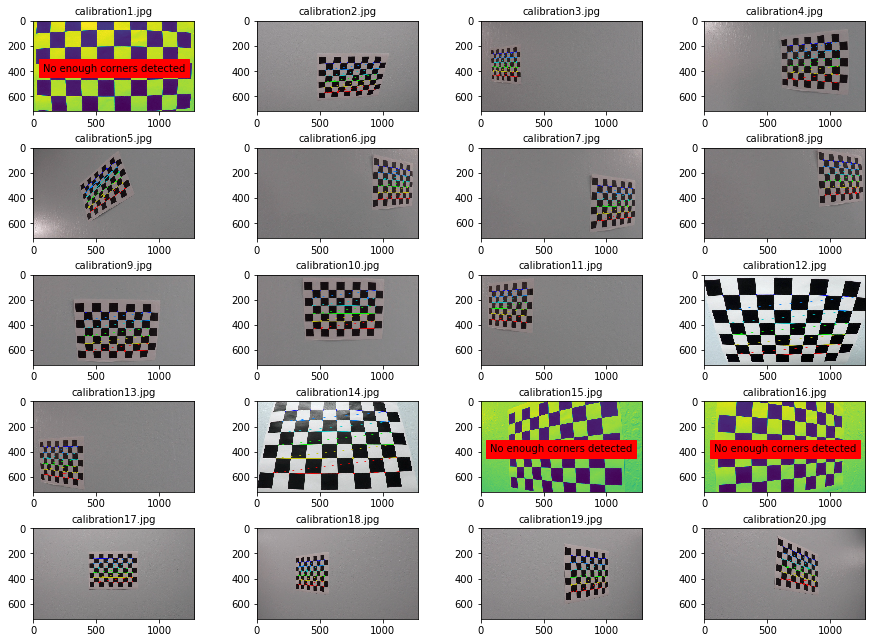

In [3]:
"""
Calibrate camera
"""
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11), squeeze=False)
fig.subplots_adjust(hspace = 0.4, wspace= 0.01)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].imshow(img)
    else:
        axs[i].imshow(gray)
        axs[i].text(x = 75, y = 400, s = "No enough corners detected", fontsize=10, backgroundcolor='red')
        print(fname,"doesnt have enough corners detected.")
    axs[i].set_title('calibration%d.jpg' %(i+1), fontsize=10)
fig.savefig('output_images/calibration.png', bbox_inches = 'tight')

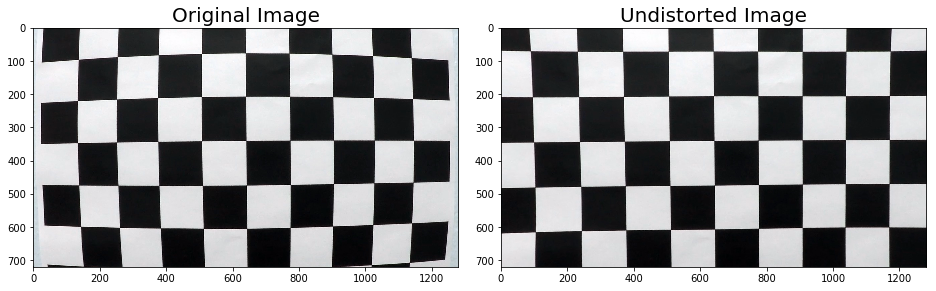

In [4]:
"""
Undistort images based on objpoints and imgpoints gained above
"""

def undistortImage(img, objpoints, imgpoints):
    """
    Takes an image and undistort it with calibration data objpoints and imgpoints
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

original_image = cv2.imread('camera_cal/calibration1.jpg')
undistorted_image = undistortImage(original_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,11))
f.subplots_adjust(hspace = 0.2, wspace = 0.1)
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=20)
f.savefig('output_images/undistorted_image.png', bbox_inches = 'tight')

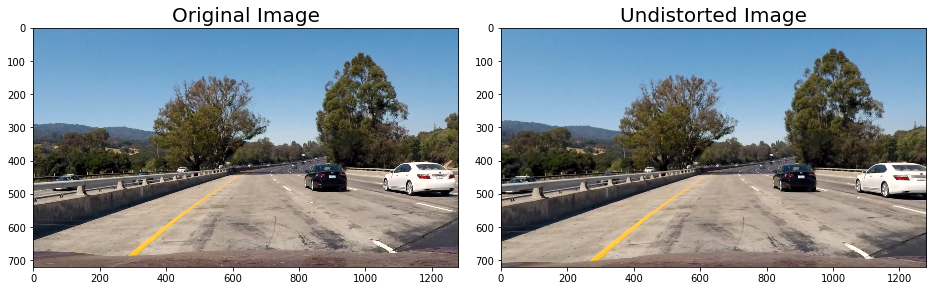

In [5]:
"""
Apply undistortImage() to raw images
"""

original_image = cv2.imread('test_images/test1.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
undistorted_image = undistortImage(original_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,11))
f.subplots_adjust(hspace = 0.2, wspace = 0.1)
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=20)
f.savefig('output_images/undistorted_test1.png', bbox_inches = 'tight')


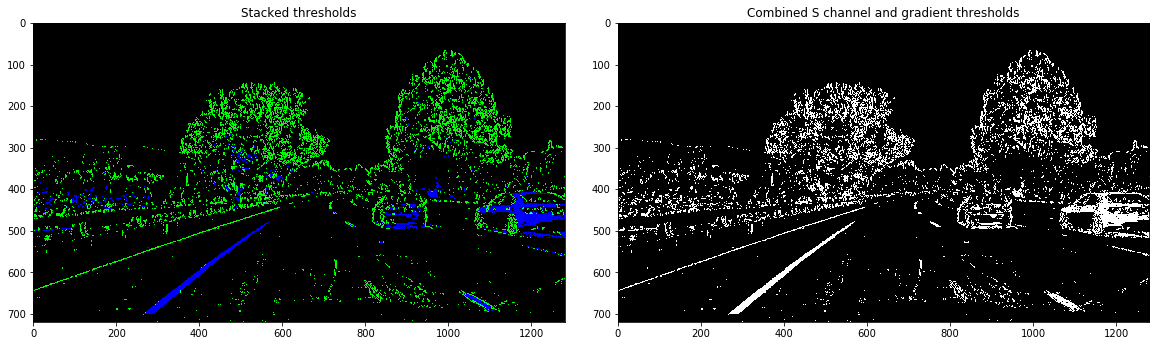

In [6]:
"""
Use color transforms, gradients, etc., to create a thresholded binary image.
"""

# Convert to HLS color space and separate the S channel
hls_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
s_channel = hls_image[:,:,2]

# Grayscale image
gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = 0.2, wspace = 0.1)
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
f.savefig('output_images/thresholded_binary_image.png', bbox_inches = 'tight')

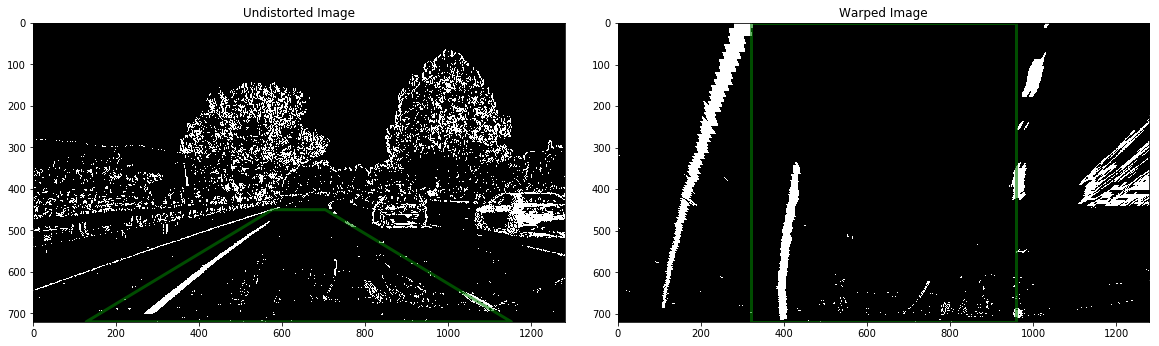

In [7]:
def warpImage(undistorted_image, src, dst):
    h, w = undistorted_image.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted_image, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped

h,w = combined_binary.shape[:2]
offset_original = 0.05*w
offset_warp = (1/4)*w

# define source and destination points for transform
src = np.float32([(0.5*w - offset_original, (5/8)*h),
                  (0.5*w + offset_original, (5/8)*h), 
                  (0.1*w,h), 
                  (0.9*w,h)])
dst = np.float32([(offset_warp,0),
                  (w-offset_warp,0),
                  (offset_warp,h),
                  (w-offset_warp,h)])

binary_warped = warpImage(combined_binary, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = 0.2, wspace = 0.1)
ax1.imshow(combined_binary, cmap='gray')
x1 = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y1 = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x1, y1, color='green', alpha=0.6, linewidth=3, solid_capstyle='round')
ax1.set_title('Undistorted Image')
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
x2 = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y2 = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x2, y2, color='green', alpha=0.6, linewidth=3, solid_capstyle='round')
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image')
f.savefig('output_images/warped_image.png', bbox_inches = 'tight')

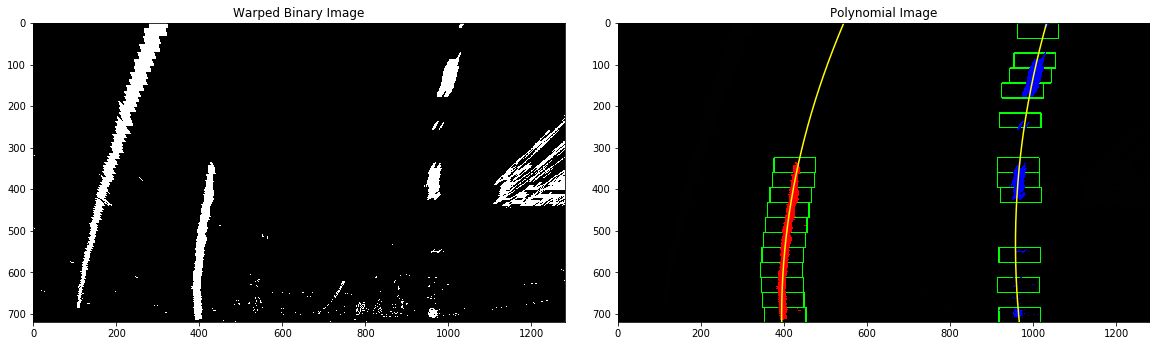

In [16]:
def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows = 20, margin = 50, minpix = 50)

    # Fit a second order polynomial to each using `np.polyfit`
    left_coeff = np.polyfit(lefty, leftx, 2)
    right_coeff = np.polyfit(righty, rightx, 2)

    y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_coeff, right_coeff, y


polynomial_image, left_coeff, right_coeff, y = fit_polynomial(binary_warped)

# Plotting warped binary and polynomial images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = 0.2, wspace = 0.1)
ax1.set_title('Warped Binary Image')
ax1.imshow(binary_warped, cmap='gray')
ax2.set_title('Polynomial Image')
try:
    left_fitx = left_coeff[0]*y**2 + left_coeff[1]*y + left_coeff[2]
    right_fitx = right_coeff[0]*y**2 + right_coeff[1]*y + right_coeff[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*y**2 + 1*y
    right_fitx = 1*y**2 + 1*y

plt.plot(left_fitx, y, color='yellow')
plt.plot(right_fitx, y, color='yellow')
ax2.imshow(polynomial_image)
f.savefig('output_images/polynomial_image.png', bbox_inches = 'tight')

In [18]:
def measure_curvature_pixels(left_coeff, right_coeff, y):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(y)
    
    # Calculation of R_curve (radius of curvature)
    left_curvature = ((1 + (2*left_coeff[0]*y_eval + left_coeff[1])**2)**1.5) / np.absolute(2*left_coeff[0])
    right_curvature = ((1 + (2*right_coeff[0]*y_eval + right_coeff[1])**2)**1.5) / np.absolute(2*right_coeff[0])
    
    return left_curvature, right_curvature


# Calculate the radius of curvature in pixels for both lane lines
left_curvature, right_curvature = measure_curvature_pixels(left_coeff, right_coeff, y)

print(left_curvature, right_curvature)

1659.55063335 1921.76028321
